## **Diagnosis of Presence of Heart Disease Based on Age, Cholesterol, And Resting Blood Pressure**

**Names:** Srijan Sanghera, Sharon Feng, Annie Wang, Mairin Leitch

### **Introduction**
Coronary artery disease (CAD), characterized by the narrowing of coronary arteries, demand accurate diagnostic tools for timely intervention and treatment (Detrano, Robert C. et al.,1989). Traditionally, this has been achieved through invasive procedures like angiography. However, there is a growing interest in developing non-invasive methods that utilize patient demographics and basic clinical information for CAD diagnosis. This study aims to address this need by evaluating the diagnosis of the presence of heart disease using essential parameters: age, cholesterol levels, and resting blood pressure based on the database from Hungarian Institute. <br> Our chosen data set was collected by Andras Janosi, M.D. in the Hungarian Institute of Cardiology, Budapest and is applicable for heart disease diagnosis. 

**Research Question:** Is the given new patient having heart disease or not based on their Age, Cholesterol, and Resting Blood Pressure?

### **Exploratory Analysis**

In [107]:
#import packages:
library(tidyverse)
library(tidymodels)
library(repr)

In [108]:
#loading data in:
URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
heart <- read_delim(URL, delim = ",", col_names = FALSE) |>
        rename(age = X1, sex = X2, cp = X3, trestbps = X4, chol = X5, fbs = X6, restecg = X7, thalach = X8, exang = X9,
               oldpeak = X10, slope = X11, ca = X12, thal = X13, num_predicted = X14)

#Cleaning and wrangling data
heart_data <- heart |>
    select(age, chol, trestbps, num_predicted) |>
    filter(chol != "?", trestbps != "?") |>
    mutate(num_predicted = as.factor(num_predicted),
           num_predicted = fct_recode(num_predicted, "present" = "1", "absent" = "0"),
           chol = as.numeric(chol),
           trestbps = as.numeric(trestbps))
heart_data


#split data into training and testing
heart_split <- initial_split(heart_data, prop = 0.75, strata = num_predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,chol,trestbps,num_predicted
<dbl>,<dbl>,<dbl>,<fct>
28,132,130,absent
29,243,120,absent
30,237,170,absent
31,219,100,absent
32,198,105,absent
32,225,110,absent
32,254,125,absent
33,298,120,absent
34,161,130,absent


In [109]:
#Summarize:
disease_vs_healthy <- heart_train |>
    group_by(num_predicted) |>
    summarize(count = n(), 
              min_age = min(age), max_age = max(age), mean_age = mean(age),
              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
              min_trestbsp = min(trestbps), max_trestbps = max(trestbps), mean_trestbps = mean(trestbps))
disease_vs_healthy

num_predicted,count,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_trestbsp,max_trestbps,mean_trestbps
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absent,126,29,62,47.16667,85,468,241.4683,100,190,129.754
present,75,31,65,49.29333,117,529,264.0400,92,200,133.880


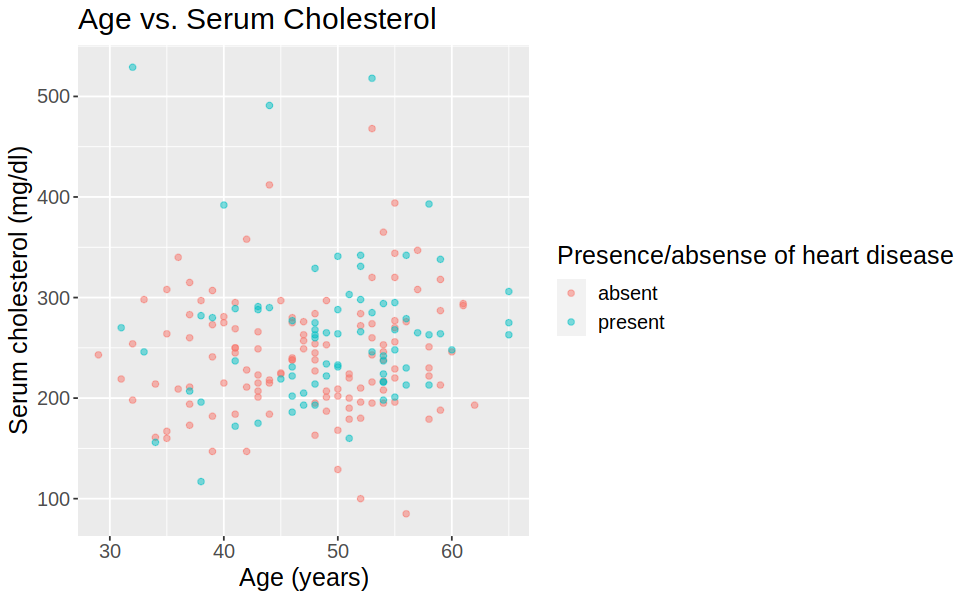

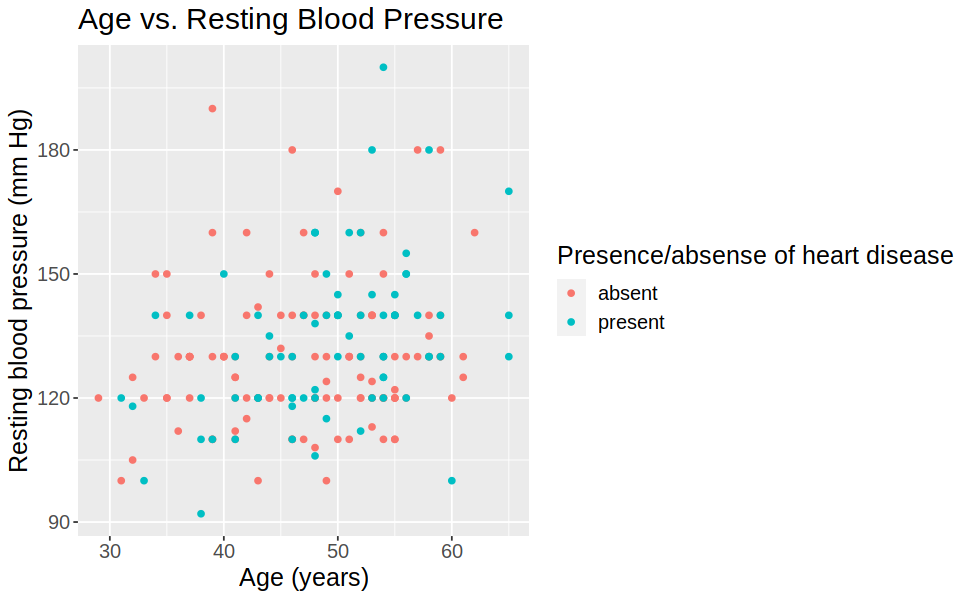

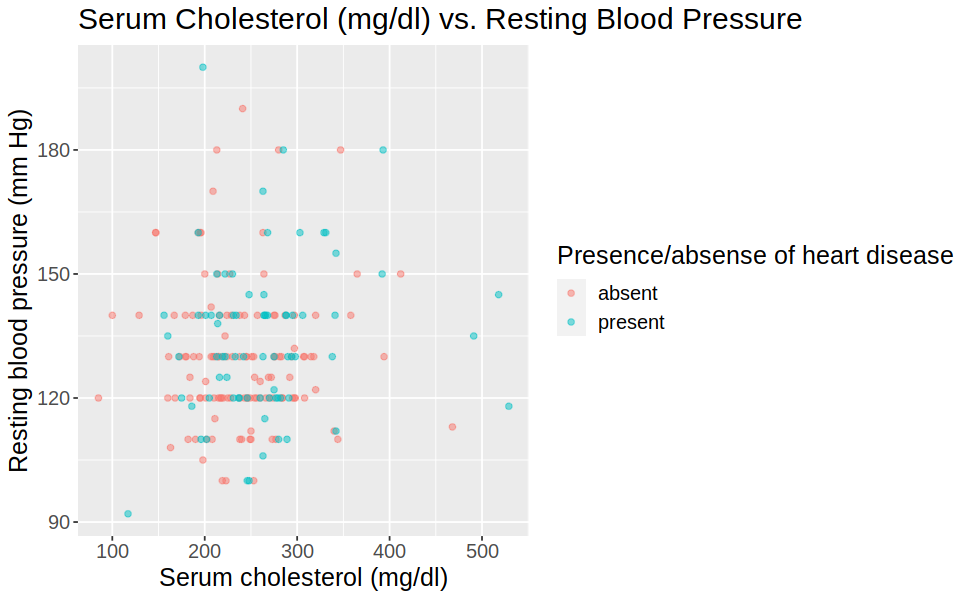

In [113]:
#visualising training data
options(repr.plot.width = 8, repr.plot.height = 5) 

age_vs_cholesterol <- heart_train |>
    ggplot(aes(x = age, y = chol, color = num_predicted)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (years)", y = "Serum cholesterol (mg/dl)", color = "Presence/absense of heart disease") +
    ggtitle("Age vs. Serum Cholesterol") +
    theme(text = element_text(size=15))
age_vs_cholesterol

age_vs_trestbps <- heart_train |>
    ggplot(aes(x = age, y = trestbps, color = num_predicted)) +
    geom_point() +
    labs(x = "Age (years)", y = "Resting blood pressure (mm Hg)", color = "Presence/absense of heart disease") +
    ggtitle("Age vs. Resting Blood Pressure") +
    theme(text = element_text(size=15))
age_vs_trestbps

chol_vs_trestbps <- heart_train |>
    ggplot(aes(x = chol, y = trestbps, color = num_predicted)) +
    geom_point(alpha = 0.5) +
    labs(x = "Serum cholesterol (mg/dl)", y = "Resting blood pressure (mm Hg)", color = "Presence/absense of heart disease") +
    ggtitle("Serum Cholesterol (mg/dl) vs. Resting Blood Pressure") +
    theme(text = element_text(size=15))
chol_vs_trestbps

### **Methods**

### **Expected outcomes and significance**

##### **References**:
Detrano, R.C., Jánosi, A., Steinbrunn, W., Pfisterer, M.E., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American journal of cardiology, 64 5, 304-10 .